In [658]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

# ------------------------------------------------------------------------------
# Parameters & Constants for Phase-Field Model
# ------------------------------------------------------------------------------

M = 1.0 #mobility constant, m^5/(J*s)
kappa = 4.0 #gradient energy constant, J/m
xmax = 50.0 #physical domain size, m
nx = 1000 #number of spatial discretization points
dx = xmax/(nx-1) #spatial discretization step, m
x = np.linspace(-xmax/2, xmax/2, nx) #spatial grid
nsteps = 100000 #number of time steps
trans = 0 #number of transition steps between two phases
dt = 0.1
# ------------------------------------------------------------------------------
# Parameters & Constants for Diffusion 
# ------------------------------------------------------------------------------

from scipy.constants import elementary_charge as e, Avogadro as NA, k as kB

epsilon = 1.0
i_a = 0 #-8e6           # Applied current density [A/m²]
sigma = 1.0          #conductivity (for the current density to electric field proportionality)
k = 1.0 #kB

# ------------------------------------------------------------------------------
# Reference values from literature
# ------------------------------------------------------------------------------
T = 1.0 #1273.0               # K, temperature
c_ref = 1660               # mol/m^3, reference concentration
rho_ref = 1.6e6            # C/m^3, reference charge density
varphi_ref = k * T / e     # V, reference potential
interface_width = 4.0      # nm, width of the phase-field interface (0 < C < 1)
lambda_D = 1.0             # nm, Debye length

In [659]:
# make a dictionary with the dict () constructor for all species

charges = {
    "vac" : 2.0,
    "elec" : -1.0,
    "yzr" : -1.0,
}

# concentrations -> [mol/m³]

vac = {
    "mu_YSZ" : 0.12,
    "mu_anode" : 0.2,
    "diffusivity" : 1.0e-5,
    "bulk_anode_conc" : 83.0,
    "bulk_YSZ_conc" : 830.0,
    "rate_constant" : abs(i_a / e * NA * charges["vac"]),
}

elec = {
    "mu_YSZ" : 0.0,
    "mu_anode" : 0.0,
    "diffusivity" : 2.0e-4,
    "bulk_YSZ_conc" : 0.0,
    "bulk_anode_conc" : charges["vac"] * vac["bulk_anode_conc"],
    "rate_constant" : abs(i_a / e * NA * charges["elec"]),
}

yzr = {
    "mu_YSZ" : 0.0,
    "mu_anode" : 0.0,
    "diffusivity" : 5.0e-20,
    "bulk_YSZ_conc" : 1660.0,
    "bulk_anode_conc" : 0.0,
    "rate_constant" : 0.0,
}

conc_boundaries = {
    "vac" : dict(YSZ = - ( i_a / e * NA * charges["vac"] ) / vac["diffusivity"], anode = 0.0),
    "elec" : dict(YSZ = 0.0, anode = (i_a / e * NA * charges["elec"]) / elec["diffusivity"]),
    "yzr" : dict(YSZ = 0.0, anode = 0.0),
}

In [660]:
def CrankNicolson(n, dt_cahn=0.01, total_time=1.0, M=1.0, kappa=4.0, L=50.0):
    """
    Improved Crank-Nicolson implementation for Cahn-Hilliard equation
    with more implicit treatment of the nonlinear term
    """
     # FIXED: Use reasonable number of time steps
    N = int(total_time / dt_cahn)  # Much more reasonable!
    print(f"Cahn-Hilliard will use {N} time steps with dt = {dt_cahn}")
    
    # Spatial domain
    x0, xL = -L/2, L/2
    dx = (xL - x0)/(n-1)
    
    # Time domain
    dt = 0.1
    t0, tF = 0, dt*N
    
    # Grid
    xspan = np.linspace(x0, xL, n)
    tspan = np.linspace(t0, tF, N)
    
    # Laplacian operator matrix with Neumann BCs
    lambda_lap = 1.0 / dx**2
    maindiag = -2 * lambda_lap * np.ones(n)
    offdiag = lambda_lap * np.ones(n-1)
    
    # Create sparse laplacian matrix
    laplacian = sparse.diags([offdiag, maindiag, offdiag], [-1, 0, 1], 
                           shape=(n, n), format='csr')
    
    # Apply Neumann boundary conditions
    laplacian[0, 0] = -lambda_lap
    laplacian[0, 1] = lambda_lap
    laplacian[n-1, n-1] = -lambda_lap
    laplacian[n-1, n-2] = lambda_lap
    
    def df_dC(C):
        """Derivative of free energy density f'(C) = 4C(1-C)(1-2C)"""
        return 4 * C * (1 - C) * (1 - 2 * C)
    
    def d2f_dC2(C):
        """Second derivative of free energy density f''(C)"""
        return 4 * (1 - 6*C + 6*C**2)
    
    # Initialize solution matrix
    U = np.zeros((n, N))
    
    # Initial condition (same as your original)
    comp = np.zeros(n)
    comp[0:int(n/2)] = 0.0
    comp[int(n/2):n] = 1.0
    U[:, 0] = comp
    
    # Time stepping
    for k in range(1, N):
        u_old = U[:, k-1]
        u_new = u_old.copy()  # Initial guess
        
        # Newton iteration for implicit treatment
        for newton_iter in range(10):  # Max Newton iterations
            # Current derivatives
            df_curr = df_dC(u_new)
            d2f_curr = d2f_dC2(u_new)
            
            # Chemical potential and its Jacobian
            lap_u = laplacian @ u_new
            mu = df_curr - kappa * lap_u
            
            # Residual: (u_new - u_old)/dt - M * nabla^2(mu) = 0
            residual = (u_new - u_old)/dt - M * (laplacian @ mu)
            
            # Jacobian terms
            # d(mu)/du = d2f_dC2 - kappa * laplacian
            dmu_du = sparse.diags(d2f_curr) - kappa * laplacian
            
            # Full Jacobian: I/dt - M * laplacian * dmu_du
            jacobian = sparse.eye(n)/dt - M * laplacian @ dmu_du
            
            # Newton update
            try:
                delta_u = spsolve(jacobian, residual)
                u_new = u_new - delta_u
                
                # Check convergence
                if np.linalg.norm(delta_u) < 1e-10:
                    break
            except:
                print(f"Linear solve failed at time step {k}")
                break
        
        U[:, k] = u_new
        
        # Print progress
        if k % (N//10) == 0:
            print(f"Time step {k}/{N} completed")
    
    return u_new
#-------------------------------------------------------------------
# Note: The above code is a complete implementation of the Cahn-Hilliard phase-field model using the Crank-Nicolson method.

In [661]:
#initialize the concentrations of each species and electrostatic potential of the system

# ------------------------------------------------------------------------------
# Vacancy concentrations [mol/m³]
# ------------------------------------------------------------------------------

c_vac = np.zeros(nx)

c_vac[0:int(nx/2)] = vac["bulk_YSZ_conc"]
c_vac[int(nx/2):nx] = vac["bulk_anode_conc"]

#c_vac = c_vac / c_ref  # normalize by reference concentration

# ------------------------------------------------------------------------------
# Yttrium-stabilized Zirconium concentrations [mol/m³]
# ------------------------------------------------------------------------------

c_yzr = np.zeros(nx)

c_yzr[0:int(nx/2)] = yzr["bulk_YSZ_conc"]
c_yzr[int(nx/2):nx] = yzr["bulk_anode_conc"]

#c_yzr = c_yzr / c_ref  # normalize by reference concentration

# ------------------------------------------------------------------------------
# Electron concentrations [mol/m³]
# ------------------------------------------------------------------------------

c_elec = np.zeros(nx)

c_elec[0:int(nx/2)] = elec["bulk_YSZ_conc"]
c_elec[int(nx/2):nx] = elec["bulk_anode_conc"]

#c_elec = c_elec / c_ref  # normalize by reference concentration

# ------------------------------------------------------------------------------
# Initialize the electrostatic potential field
# ------------------------------------------------------------------------------

varphi = np.zeros(nx) #potential field

# ------------------------------------------------------------------------------

In [662]:
# ------------------------------------------------------------------------------
# function to calculate the charge density, rho

# function to calculate the potential, varphi 

varphi_init = np.zeros(nx)  # Initial potential field
varphi_init[:nx//2] = 0.0  # Left side potential
varphi_init[nx//2:] = 0.102 # Right side potential

def gauss_seidel_1D(varphi_s, rho, i_a, sigma, maxiter = 100, tol = 1e-4):
    varphi = varphi_s.copy()  # Make a copy of the initial potential
    # Get the length of potential array (1-D)
    N = len(varphi)
    
    # Iterate until convergence or maximum iterations reached
    for it in range(maxiter):
        varphi_old = varphi.copy()

        varphi[0] = 0.0
        
        varphi[-1] = varphi[-2] + dx * i_a/sigma # Boundary condition at the right end

        # Update the potential using the Gauss-Seidel formula
        for j in range(1, N-1):
            varphi[j] = 0.5 * (varphi[j+1] + varphi[j-1] + rho[j] * dx**2 / epsilon)
        
        # Check for convergence
        if np.max(np.abs(varphi - varphi_old)) < tol:
            #print(f"Converged after {it} iterations.")
            return varphi
    
    return varphi

In [663]:
def laplacian_chem(f, deltax, mu_YSZ, mu_anode):
    f[0] = mu_YSZ
    f[-1] = mu_anode
    lap = np.zeros_like(f)
    for i in range(1, len(f)-1):
        lap[i] = (f[i-1] - 2*f[i] + f[i+1]) / (deltax ** 2)
    return lap

def laplacian_conc(f, deltax, left, right):
    lap = np.zeros_like(f)

    for i in range(1, len(f)-1):

        lap[i] = (f[i-1] - 2*f[i] + f[i+1]) / (deltax ** 2)
    
    # use ghost point to enforce boundary conditions on the left and right sides (again, neumann)
    lap[0] = (f[1] - 2*f[0] + (f[1] - 2 * deltax * left)) / (deltax ** 2)
    lap[-1] = (f[-2] - 2*f[-1] + (f[-2] + 2 * deltax * right)) / (deltax ** 2)
    return lap

def laplacian_elec(f, deltax):
    # Dirichlet boundary condition for the electric potential for electrolyte
    lap = np.zeros_like(f)
    f[0] = 0.0
    for i in range(1, len(f)-1):
        lap[i] = (f[i-1] - 2*f[i] + f[i+1]) / (deltax ** 2)
    lap[-1] = (f[-2] - 2*f[-1] + (f[-2] + 2 * deltax * i_a / sigma)) / (deltax ** 2)

    return lap

In [664]:
# Okay now for the chemical potential

def interpolator(C):
    # Interpolation function for the chemical potential, polynomial
    h = C**3 * ( 6 * C**2 - 15 * C + 10)
    return h
    
# function to calculate the chemical potential, mu
def chemical_potential(C, mu_YSZ, mu_anode):
    mu = mu_YSZ + (mu_anode - mu_YSZ) * interpolator(C)
    return mu

In [665]:
def interface_locator(C):
    # ensures interface reaction only occurs at interface
    lambda_C = C ** 2 * (1 - C) ** 2
    return lambda_C

# maybe because its in reduced units, we need to scale the diffusivity by the reference concentration

def diffusion (varphi, C, c, mu, D, z, R, left, right, mu_YSZ, mu_anode):
    # first term = chemical potential term
    chem_term = ( D * c / ( k * T )) * laplacian_chem(mu, dx, mu_YSZ, mu_anode)
    constants = D * c / ( k * T )

    # second term = concentration gradient term
    conc_term = D * laplacian_conc(c, dx, left, right)

    # third term = electrostatic potential term
    elec_term = ( D * z * e / ( kB * T )) * laplacian_elec(varphi, dx)

    # fourth term = sink term
    # need to first define K (normalization constant)
    integral = np.trapz(interface_locator(C), dx = dx) 
    K  = 1.0 / integral
    sink_term = R * K * interface_locator(C)

    #print("sink_term", sink_term)

    c += (chem_term + conc_term + elec_term + sink_term) * dt

    return c


In [666]:
#intialize the composition field

comp = np.zeros(nx) #composition field

comp[0:int(nx/2 - trans/2)] = 0.0 #left phase

comp[int(nx/2 + trans/2):nx] = 1.0 #right phase

for i in range (trans):
    comp[int(nx/2 - trans/2 + i)] = 1.0/trans * i #linear transition

print(comp.shape)

(1000,)


Running initial Cahn-Hilliard solve...
Cahn-Hilliard will use 10 time steps with dt = 0.01
Time step 1/10 completed
Time step 2/10 completed
Time step 3/10 completed
Time step 4/10 completed
Time step 5/10 completed
Time step 6/10 completed
Time step 7/10 completed
Time step 8/10 completed
Time step 9/10 completed
Starting electrochemical simulation with 1000 steps...
Electrochemical step: 0/1000
Electrochemical step: 100/1000
Electrochemical step: 200/1000
Electrochemical step: 300/1000
Electrochemical step: 400/1000
Electrochemical step: 500/1000
Electrochemical step: 600/1000
Electrochemical step: 700/1000
Electrochemical step: 800/1000
Electrochemical step: 900/1000


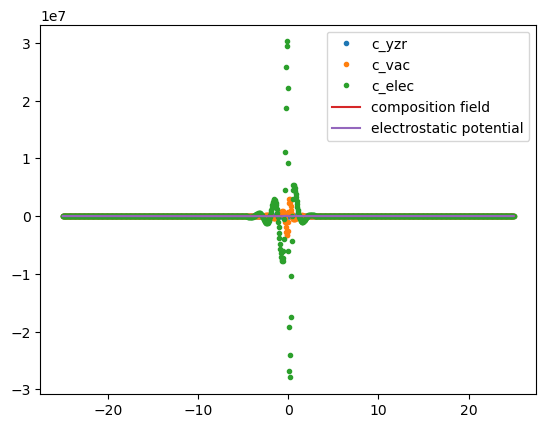

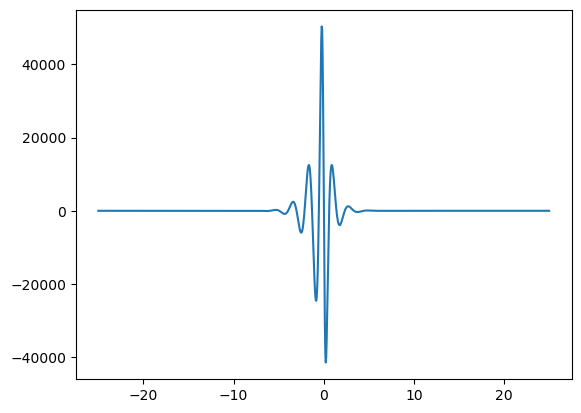

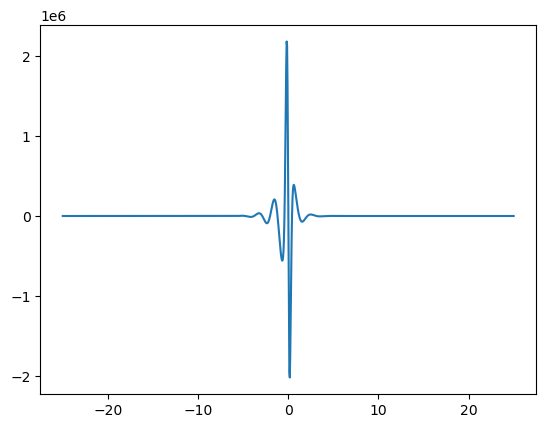

In [ ]:
    # MUCH smaller number of electrochemical time steps for testing
nsteps_test = 1000
    
    # Run Cahn-Hilliard once at the beginning
print("Running initial Cahn-Hilliard solve...")
comp_final = CrankNicolson(nx, dt_cahn=0.01, total_time=0.1, M=1.0, kappa=4.0, L=xmax)
    
    # Use the result for electrochemical simulation
comp = comp_final  # This is now a 1D array, not 2D
    
print(f"Starting electrochemical simulation with {nsteps_test} steps...")

for time in range(nsteps_test):
    if time % 100 == 0:
        print(f"Electrochemical step: {time}/{nsteps_test}")
        #for Poisson's equation (not species-specific)
    rho = - e * NA * ( charges["vac"] * c_vac + charges["elec"] * c_elec + charges["yzr"] * c_yzr )
    rho /= rho_ref  # normalize by reference charge density
        #print("rho",rho)
        
    varphi = gauss_seidel_1D(varphi_init, rho, i_a, sigma)

        #find the chemical potential for every species:
    mu_vac = chemical_potential(comp, vac["mu_YSZ"], vac["mu_anode"])
    mu_elec = chemical_potential(comp, elec["mu_YSZ"], elec["mu_anode"])
    mu_yzr = chemical_potential(comp, yzr["mu_YSZ"], yzr["mu_anode"])

        #update the concentration for every species: 
    c_vac = diffusion(varphi, comp, c_vac, mu_vac, vac["diffusivity"], charges["vac"], vac["rate_constant"], conc_boundaries["vac"]["YSZ"], conc_boundaries["vac"]["anode"], vac["mu_YSZ"], vac["mu_anode"])
    c_elec = diffusion(varphi, comp, c_elec, mu_elec, elec["diffusivity"], charges["elec"], elec["rate_constant"], conc_boundaries["elec"]["YSZ"], conc_boundaries["elec"]["anode"], elec["mu_YSZ"], elec["mu_anode"])
    c_yzr = diffusion(varphi, comp, c_yzr, mu_yzr, yzr["diffusivity"], charges["yzr"], yzr["rate_constant"], conc_boundaries["yzr"]["YSZ"], conc_boundaries["yzr"]["anode"], yzr["mu_YSZ"], yzr["mu_anode"])

    fixed_charges = charges["vac"] * c_vac[-1] + charges["yzr"] * c_yzr[-1]
    c_elec[-1] = - fixed_charges / charges["elec"]
    c_elec[-1] = max(c_elec[-1], 0.0)

plt.plot(x, c_yzr, ".", label='c_yzr')
plt.plot(x, c_vac, ".", label='c_vac')
plt.plot(x, c_elec, ".", label='c_elec')
plt.plot(x, comp, label='composition field')
plt.plot(x, varphi, label='electrostatic potential')
plt.legend()
plt.show()

plt.plot(x, varphi, label='electrostatic potential')
plt.show()

plt.plot(x, rho)
plt.show()